In [36]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm
import random
from sklearn.utils import shuffle
import seaborn as sns
# sns.set(style="darkgrid")

In [37]:
from common import get_data, get_freq_data, signal_cyclic_shift, get_ref_time, generate_multi_signal

In [38]:
X_origin, y_origin = get_data(data_path='./data/na62_11_pulses.txt', is_one_signal=False)
mean_argmin =  int(np.argmin(X_origin, axis=1).mean())

In [39]:
X_one_signal, y_one_signal = get_data('./data/na62_11_pulses.txt', is_one_signal=True)

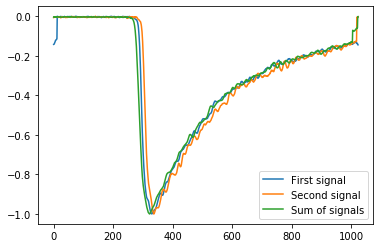

{'first_impulse': array([-0.12014796, -0.11786103, -0.11707826, ..., -0.12852823,
        -0.12320998, -0.12092306]),
 'second_impulse': array([-0.00486188, -0.00484367, -0.00305006, ..., -0.00304095,
        -0.00395142, -0.00305006]),
 'multi_ref_time': 161,
 'multi_impulse': array([-0.00382703, -0.00420847, -0.00254653, ..., -0.05821868,
        -0.00221567, -0.00176142])}

In [41]:
generate_multi_signal(X_origin, y_origin, 10, 1, ARGMIN_DISTR, to_plot=True)

In [42]:
alpha = 5
tau = 50

first_signal = X_origin[0]
second_signal = X_origin[1]
second_signal = signal_cyclic_shift(second_signal, tau)
new_signal = first_signal + alpha*second_signal

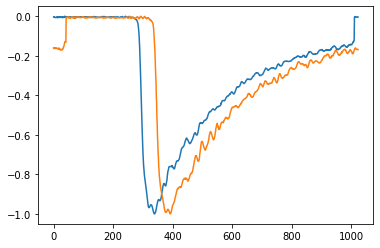

In [43]:
plt.plot(first_signal)
plt.plot(second_signal)

In [44]:
def prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=1000, to_print=False,\
                                                                         start_point=70, end_point=950):
    pos_size = int(data_size/2)
    neg_size = data_size - pos_size
    
    X = []
    y = []
    for i in range(data_size):
        alpha = random.choice(alpha_range)
        tau = random.choice(tau_range)
        
        signal = generate_multi_signal(X_origin, y_origin, tau, alpha,\
                                           argmin_distr=ARGMIN_DISTR)
        X.append(signal['multi_impulse'][start_point:end_point])
        y.append(signal['multi_ref_time']) 

   
    X = np.array(X)
    y = np.array(y)
   
    if to_print:
#         print("X positive shape:", X_positive.shape)
#         print("y positive shape:", y_positive.shape)
#         print("X negative shape:", X_negative.shape)
#         print("y negative shape:", y_negative.shape)
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

    return X, y

In [45]:
# alpha_range = np.array([np.around(10**i, decimals=4) for i in np.arange(0, 3.1, 0.01)])

# alpha_range = [10]
# tau_range = [0]
alpha_range = np.array([np.around(10**i, decimals=4) for i in np.arange(-3, 3.1, 0.1)])
tau_range = np.arange(-25, 25, 1)

(array([6., 7., 5., 6., 6., 6., 7., 6., 6., 6.]),
 array([-3. , -2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4,  3. ]),
 <a list of 10 Patch objects>)

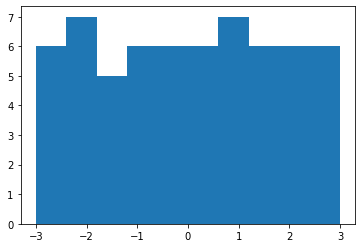

In [46]:
plt.hist(np.log10(alpha_range))

In [47]:
X, y = prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=5000, to_print=True) 

X shape: (5000, 880)
y shape: (5000,)


In [48]:
# X = get_freq_data(X, freq=15)

In [49]:
X.shape

(5000, 880)

In [50]:
from sklearn.preprocessing import normalize

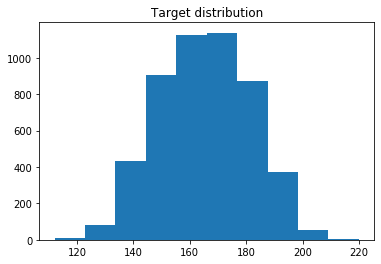

In [51]:
plt.title("Target distribution")
plt.hist(y)
plt.show()

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import PassiveAggressiveRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

In [53]:
def print_scores():
    for model in models.values():    
        model_name = type(model).__name__
        print("Regressor:", model_name)
    #         stregr = StackingRegressor(regressors=models, meta_regressor=model)
        scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
        scores = cross_validate(model, X, y, scoring=scoring, cv=5)

        r2_score_mean = scores['test_r2'].mean()
        r2_score_std = scores['test_r2'].std()
        mse_score_mean = -scores['test_neg_mean_squared_error'].mean()
        mse_score_std = scores['test_neg_mean_squared_error'].std()
        mae_score_mean = -scores['test_neg_mean_absolute_error'].mean()
        mae_score_std = scores['test_neg_mean_absolute_error'].std()
        rmse_score_mean = np.sqrt(-scores['test_neg_mean_squared_error']).mean()
        rmse_score_std = np.sqrt(-scores['test_neg_mean_squared_error']).std()

        cur_scores = [(r2_score_mean, r2_score_std), (mse_score_mean, mse_score_std),\
                          (mae_score_mean, mae_score_std), (rmse_score_mean, rmse_score_std)]
    #         print('!!!!!!!!')
    #         print("TEST")
    #         print(models_scores[type(models[0]).__name__]['r2'])
    #         print('!!!!!!!!')
        print("95% confidence interval:")
        for i, metric in enumerate(['r2', 'mse', 'mae', 'rmse'], 0):
    #         models_scores[model_name][metric].append(cur_scores[i])
            print(metric, "score: %0.5f (+/- %0.5f)" % (cur_scores[i][0], 2*cur_scores[i][1]))
        print('----------------------------------')
    print('____________________________________________________________')
    print()

In [54]:
import warnings
warnings.filterwarnings("ignore")

In [55]:
import pickle

MODEL_LOAD_PATH = './models/reference_time_regressor/'

def load_model(path):
    with open(path, 'rb') as fid:
        model = pickle.load(fid)
        return model
    
def get_models(freq=1):
    huber_reg = HuberRegressor(epsilon= 1.242, alpha= 0.01)
    ridge_reg = linear_model.Ridge(solver='lsqr', max_iter=4000, alpha=  0.513)
    lasso_reg = linear_model.Lasso(max_iter=4400, alpha= 0.00849, normalize=False)
    dt_reg = tree.DecisionTreeRegressor(min_samples_split=9, min_samples_leaf=9, min_weight_fraction_leaf=0.018, 
                                                                                                 max_features='auto')

    pa_reg = PassiveAggressiveRegressor(C=0.44, max_iter=2800, tol=2.4e-5)
    xgb_reg = load_model(MODEL_LOAD_PATH + 'XGBRegressor_freq_' + str(freq) + '.pkl')
    return {'huber': huber_reg, 'ridge': ridge_reg, 'lasso': lasso_reg, 'dt': dt_reg, 'pa':pa_reg, 'xgb': xgb_reg}

In [56]:
models = get_models()

In [57]:
print_scores()

Regressor: HuberRegressor
95% confidence interval:
r2 score: 0.95884 (+/- 0.01421)
mse score: 10.54552 (+/- 2.73545)
mae score: 2.29890 (+/- 0.36161)
rmse score: 3.24036 (+/- 0.42705)
----------------------------------
Regressor: Ridge
95% confidence interval:
r2 score: 0.97635 (+/- 0.00264)
mse score: 6.09592 (+/- 0.44153)
mae score: 1.55137 (+/- 0.07748)
rmse score: 2.46859 (+/- 0.08874)
----------------------------------
Regressor: Lasso
95% confidence interval:
r2 score: 0.97584 (+/- 0.00321)
mse score: 6.22951 (+/- 0.70863)
mae score: 1.56804 (+/- 0.10078)
rmse score: 2.49491 (+/- 0.14067)
----------------------------------
Regressor: DecisionTreeRegressor
95% confidence interval:
r2 score: 0.98038 (+/- 0.00339)
mse score: 5.05432 (+/- 0.66977)
mae score: 1.37875 (+/- 0.07004)
rmse score: 2.24695 (+/- 0.14895)
----------------------------------
Regressor: PassiveAggressiveRegressor
95% confidence interval:
r2 score: 0.88956 (+/- 0.10954)
mse score: 27.99944 (+/- 24.65430)
mae scor

KeyboardInterrupt: 

### Stacking

In [ ]:
from mlxtend.regressor import StackingRegressor


In [ ]:
for model_name, model in models.items():
    models = get_models()
    del models['pa'] ### Delete passive agressive regressor, which performs poorly
    
    print("Metaregressor:", type(model).__name__)

    stregr = StackingRegressor(regressors=list(models.values()), meta_regressor=model)
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = cross_validate(stregr, X, y, scoring=scoring, cv=5)

    r2_score_mean = scores['test_r2'].mean()
    r2_score_std = scores['test_r2'].std()
    mse_score_mean = -scores['test_neg_mean_squared_error'].mean()
    mse_score_std = scores['test_neg_mean_squared_error'].std()
    mae_score_mean = -scores['test_neg_mean_absolute_error'].mean()
    mae_score_std = scores['test_neg_mean_absolute_error'].std()
    rmse_score_mean = np.sqrt(-scores['test_neg_mean_squared_error']).mean()
    rmse_score_std = np.sqrt(-scores['test_neg_mean_squared_error']).std()

    cur_scores = [(r2_score_mean, r2_score_std), (mse_score_mean, mse_score_std),\
                      (mae_score_mean, mae_score_std), (rmse_score_mean, rmse_score_std)]
    #         print('!!!!!!!!')
    #         print("TEST")
    #         print(models_scores[type(models[0]).__name__]['r2'])
    #         print('!!!!!!!!')
    print("95% confidence interval:")
    for i, metric in enumerate(['r2', 'mse', 'mae', 'rmse'], 0):
    #         models_scores[model_name][metric].append(cur_scores[i])
        print(metric, "score: %0.5f (+/- %0.5f)" % (cur_scores[i][0], 2*cur_scores[i][1]))
    print('--------------------------------------------------------')

### Let's plot regression scores for different frequency, tau and alpha values

In [58]:
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from math import sqrt

In [65]:
alpha_values = np.array([np.around(10**i, decimals=4) for i in np.arange(-3, 3.1, 0.1)])
tau_values = range(-25, 30, 5)
freq_values = [1, 25, 50, 75, 100, 125, 150]
TIME_SCALE_COEF = 0.2
# alpha_values = np.around(np.arange(0, 100, 2), decimals=2)

In [76]:
def calculate_scores(X, y, alpha_values, tau_values, data_size=100, freq=1):
    scores_dict = {}    
    model = get_models()['xgb']
    X_freq = get_freq_data(X, freq=freq)
    model.fit(X_freq, y)

    for tau in tqdm.tqdm(tau_values):
        scores_dict[tau] = dict(zip(alpha_values, np.zeros(len(alpha_values))))
        for alpha in alpha_values:
            X_cur, y_cur = prepare_data(X_origin, y_origin, [tau], [alpha], data_size=data_size)
            X_cur = get_freq_data(X_cur, freq=freq)
            y_pred = model.predict(X_cur)

            scores_dict[tau][alpha] = np.log10(sqrt(mean_squared_error(y_pred, y_cur))) #* TIME_SCALE_COEF

    return scores_dict

In [67]:
def dict_to_arrays(scores_dict):
    x, y, z = [], [], []
    for tau, alpha_dict in scores_dict.items():
        for alpha, score in alpha_dict.items():
            x.append(tau)
            y.append(alpha)
            z.append(score)
            
    return [x, y, z]

In [68]:
import pickle

def save_obj(obj, name ):
    with open('./data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [77]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

VMIN = -0.5
VMAX = 2
STEP = 0.25
ORIGIN_FREQ = 5000

def plot_color_map(scores_dict, alpha_values, tau_values, alpha_freq=10, tau_freq=2, freq=1, cmap='hsv'):
    _, _, z = dict_to_arrays(scores_dict)
    z = np.array(z)
    Z = z.reshape((len(tau_values), len(alpha_values)))

    plt.figure(figsize=(5, 5))
    ax = plt.gca()

    plt.title("log10(RMSE), frequency = " + str(int(ORIGIN_FREQ/freq)) + ' [MHz]', weight='bold', fontsize=12) 
    plt.xlabel("Two signals ratio", fontsize=12)
    plt.ylabel("Delta t [ns]", fontsize=12)
    plt.xticks([alpha_freq*i for i in range(len(alpha_values[::alpha_freq]))], alpha_values[::alpha_freq])
    plt.yticks([tau_freq*i for i in range(len(tau_values[::tau_freq]))], [TIME_SCALE_COEF*el for el in tau_values[::tau_freq]])

    im = ax.imshow(Z, interpolation='bilinear', cmap=cmap, aspect='auto', vmin=VMIN, vmax=VMAX)
#     im = ax.imshow(Z, interpolation='bilinear', cmap=cmap, aspect='auto')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)

    cbar = plt.colorbar(im, cax=cax)
    cbar.set_ticks(np.arange(VMIN, VMAX, STEP))
    cbar.set_ticklabels(np.arange(VMIN, VMAX, STEP))
    cbar.set_label('log10(RMSE)', rotation=90, fontsize=13)

    plt.show()

In [83]:
def plot_saved_results():
    for freq in freq_values:
        scores_dict = load_obj('scores_ref_time_freq=' + str(freq))
        plot_color_map(scores_dict, alpha_values, tau_values, freq=freq, cmap='hsv')

In [ ]:
freq_values = [1, 5, 10, 15, 25, 50]
plot_saved_results()

100%|██████████| 11/11 [07:15<00:00, 39.57s/it]


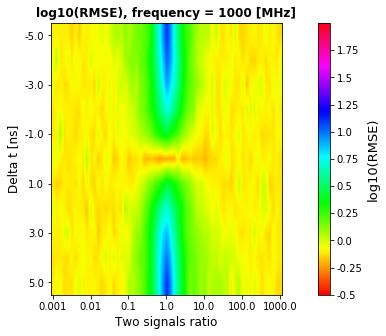

100%|██████████| 11/11 [07:14<00:00, 39.46s/it]


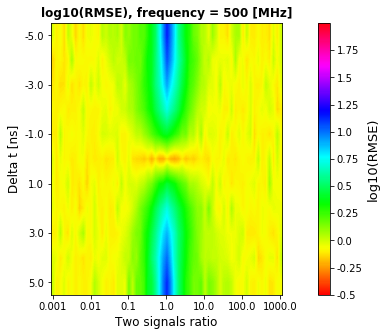

100%|██████████| 11/11 [07:15<00:00, 39.61s/it]


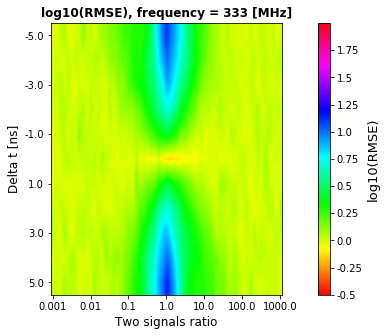

In [80]:
X_origin, y_origin = get_data(data_path='./data/na62_11_pulses.txt', is_one_signal=False)
X, y = prepare_data(X_origin, y_origin, tau_values, alpha_values, to_print=False, data_size=int(len(X_origin)))

for freq in freq_values:
    scores_dict = calculate_scores(X, y, alpha_values, tau_values, data_size=500, freq=freq)
    plot_color_map(scores_dict, alpha_values, tau_values, freq=freq)
    save_obj(scores_dict, 'scores_ref_time_freq=' + str(freq))
#     plot_score_3d(scores_dict)

In [25]:
freq_values = [1, 5, 10, 25, 50]

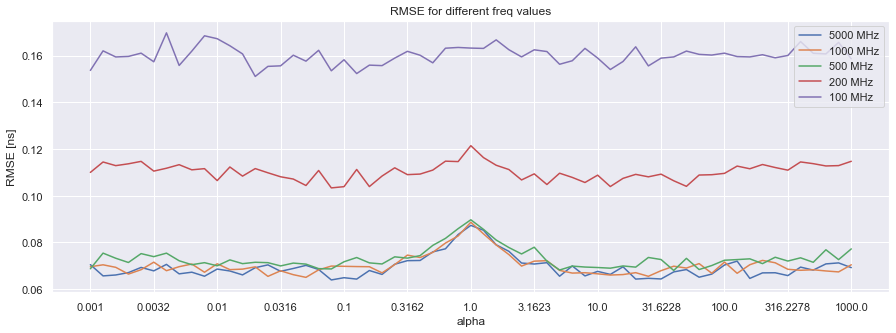

In [26]:
def process_legend_labels(x):
    return str(int(x)) + ' MHz'

X_origin, y_origin = get_data(data_path='./data/na62_11_pulses.txt', is_one_signal=False)
X, y = prepare_data(X_origin, y_origin, alpha_values, to_print=False, data_size=len(X_origin))

f, ax = plt.subplots(figsize=(15, 5))

for freq in tqdm.tqdm_notebook(freq_values):
    scores_dict = calculate_scores(X, y, alpha_values, data_size=5000, freq=freq)
    
    
    plt.plot(list(scores_dict.values()))

plt.title("RMSE for different freq values")
plt.xlabel("alpha")
plt.ylabel("RMSE [ns]")
plt.xticks(range(0, len(scores_dict.keys()), 5), list(scores_dict.keys())[::5])
plt.legend(list(map(process_legend_labels, (5000 / np.array(freq_values)))))
plt.show()

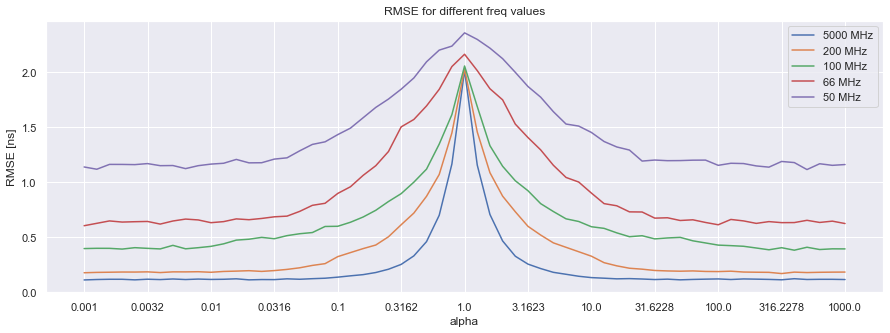

In [68]:
def process_legend_labels(x):
    return str(int(x)) + ' MHz'

X_origin, y_origin = get_data(data_path='./data/na62_11_pulses.txt', is_one_signal=False)
X, y = prepare_data(X_origin, y_origin, alpha_values, to_print=False, data_size=len(X_origin))

f, ax = plt.subplots(figsize=(15, 5))

for freq in tqdm.tqdm_notebook(freq_values):
    scores_dict = calculate_scores(X, y, alpha_values, data_size=5000, freq=freq)
    
    
    plt.plot(list(scores_dict.values()))

plt.title("RMSE for different freq values")
plt.xlabel("alpha")
plt.ylabel("RMSE [ns]")
plt.xticks(range(0, len(scores_dict.keys()), 5), list(scores_dict.keys())[::5])
plt.legend(list(map(process_legend_labels, (5000 / np.array(freq_values)))))
plt.show()

In [64]:
y[:10]

array([161, 185, 179, 161, 170, 188, 149, 182, 194, 170])

In [65]:
freq = 100
X_freq = get_freq_data(X, freq=freq)

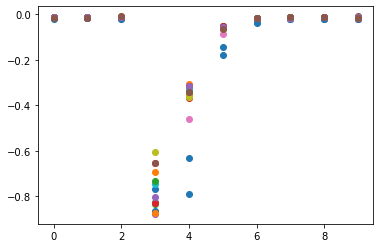

In [74]:
for i in range(100):
    if y[i] > 180:
        plt.plot(X_freq[i], 'o')

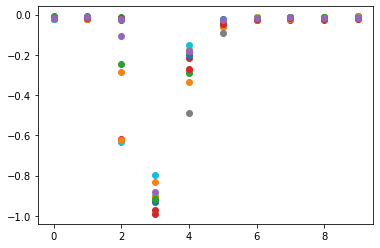

In [75]:
for i in range(100):
    if y[i] < 150:
        plt.plot(X_freq[i], 'o')

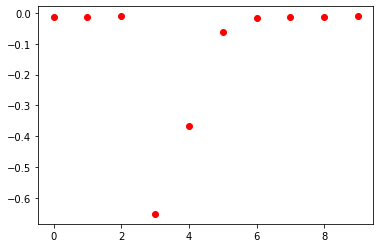

In [69]:
plt.plot(X_freq[8], 'ro')

In [ ]:
scores_dict = {}    
model = get_models()['xgb']
X_freq = get_freq_data(X, freq=freq)
model.fit(X_freq, y)

In [ ]:

    for tau in tqdm.tqdm(tau_values):
        scores_dict[tau] = dict(zip(alpha_values, np.zeros(len(alpha_values))))
        for alpha in alpha_values:
            X_cur, y_cur = prepare_data(X_origin, y_origin, [tau], [alpha], data_size=data_size)
            X_cur = get_freq_data(X_cur, freq=freq)
            y_pred = model.predict(X_cur)

            scores_dict[tau][alpha] = np.log10(sqrt(mean_squared_error(y_pred, y_cur))) #* TIME_SCALE_COEF
